# Project 5: Vehicle Detection

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.




### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I started by reading in all the vehicle and non-vehicle images. Here is an example of one of each of the vehicle and non-vehicle classes:

```sh
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
```

![alt text](examples/carnotcarexample.png "Examples")

`data_look` in `lesson_helper_functions.py` returned a count of 8792  cars and 8968  non-cars of size:  (64, 64, 3)  and data type: float32.

Next, I experimented with different HOG parameters.

```sh
orientation = 9,11,15,25
pixels per cell = 2,4,8,16
cells per block = 2,4,8
```

Calling `get_hog_features` in `lesson_helper_functions.py` with the potential values for the parameters above with a selected image to practice on, I found 9,8,2 seemed to be the best choice with 9,8,4 a close candidate.

![alt text](examples/HogVis.png "Examples")


After deciding on HOG parameters, I experimented with color spaces. Below are the results after calling `extract_features` with the color spaces. I expected that HSV would be the best color space after some research (see this [link](http://dsp.stackexchange.com/questions/2687/why-do-we-use-the-hsv-colour-space-so-often-in-vision-and-image-processing)). Also I tried to use Lab without luck [for more info](https://en.wikipedia.org/wiki/Lab_color_space). Since Lab was designed to approximate human vision I thought this might be an interesting experiment to try. I will revisit this when I review the material from Term 1 to see if it will yield better results.

*RGB*
![alt text](examples/RGBFeatures.png "RGB Features")
*HSV*
![alt text](examples/HSVFeatures.png "HSV Features")
*LUV*
![alt text](examples/LUVFeatures.png "LUV Features")
*HLS*
![alt text](examples/HLSFeatures.png "HLS Features")
*YUV*
![alt text](examples/YUVFeatures.png "YUV Features")
*YCrCb*
![alt text](examples/YCRCBFeatures.png "YCrCb Features")

Another useful link I found is [here](http://www.poynton.com/notes/colour_and_gamma/ColorFAQ.html). What I learned is that RGB is the least useful for finding usable information. In the end and as can be seen, YCrCb (at least for this data set) is the most useful choice of the bunch after normalization.

Lastly, before moving onto the next section, I tried some different values for spatial binning and hist bins - 8,16,32,64. In general, spatial binning value of (32,32) appeared to most optimal and I also used hist bin value of 32.

![alt text](examples/spatialbin_histbins.png "Visual Representation of images")
![alt text](examples/8x8x8sp.png "Spatial binning (8,8), hist bin=8")
![alt text](examples/16x16x16sp.png "Spatial binning (16,16), hist bin=16")
![alt text](examples/32x32x32sp.png "Spatial binning (32,32), hist bin=32")

Using 32x32x3 is 3072 features which is the value for spatial binning I chose. Alternatively, I probably could have used 24x24x3. I tried 16x16x3 which is 768 features, 8x8x3 is 192 features (too few) and 64x64x3 was over 12k features (not necessary). Generally, I believe the value chosen depends on the data set (cars, faces, breast cancer x-rays).


### 2. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

For the classifier, sklearn has a python notebook where you can [compare different classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). The ones included were: 
- KNeighborsClassifier(3)
- SVC(kernel="linear", C=0.025)
- SVC(gamma=2, C=1)
- GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
- DecisionTreeClassifier(max_depth=5)
- RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
- MLPClassifier(alpha=1)
- AdaBoostClassifier()
- GaussianNB()
- QuadraticDiscriminantAnalysis()

I modified the notebook to print the classifier and score using the dataset from the lesson instead of plotting. For this project, the accuracy is the most interesting.

In the end, I used the example LinearSVC classifier from class. In general, linear classifiers performed well on this dataset. I used the default values which used l2 reglurization and squared hinge loss and it performed well enough > 99% accuracy. Most other classifier were in the range of 90+% accuracy. I referenced this [link](http://cs231n.github.io/linear-classify/) on Linear Classification. One other thing was I split up the data into training and test data as has been done in the other projects. The code is below for reference and also down after `extract_features` in `lesson_helper_functions.py`.

```
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
# Check the training time for the SVC
svc.fit(X_train, y_train)
```


### 3. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
I decided to use the `find_cars` method in `lesson_helper_functions.py` which takes the image, the area to search defined by y_start and y_stop, converts to the chosen color space (YCrCb), resizes it, breaks it into the 3 channels, calculate the number of features per block based on orientation (9) x (cells per block)^2, move the sliding windown by 2 cells within the chose 8 cells (75% overlap). I chose to only search 8x8 cells per block with 75% overlap for two reasons - (1) experimentation with larger sizes did not yield better results and (2) smaller sizes while maybe can be more accuarate, it was CPU-intensive. My objective with the hardware used (my laptop), I wanted to use parameters that allowed relatively faster searching and minimize the number of windows. With these windows as you'll see next, it predicted correctly with high accuracy.


### 4. Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?
As you see in the first two images, the trained classifier found the cars, but did not classify any in the third. I didn't need to do much optimization on the classifer as mentioned earlier. I achieved >99% accuracy with the data set provided initially. If I needed to improve the accuracy of the classifier, I would have used the `GridSearchCV` from scikit-learn and the Udacity provided data.

![Test Image 1 after being processed by find_cars](examples/findcars1.png "Test Image 1 after being processed by find_cars")
![Test Image 2 after being processed by find_cars](examples/test1findcars.png "Test Image 2 after being processed by find_cars")
![Test Image 3 after being processed by find_cars](examples/test2findcars.png "Test Image 3 after being processed by find_cars")


### 5. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

[![ScreenShot](project_video_vehicle_detectio5n.mp4)](project_video_vehicle_detection5.mp4)

I'm not sure how to embed videos in markdown. It is `project_video_vehicle_detection5.mp4` if clicking on it doesn't work.

### 6. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

To add heat to the list of bounding boxes classified as having cars within them, `add_heat` in `lesson_helper_functions.py` is called and adds one to the pixels within the box (heat). Next, in `apply_threshold` simply rejects and area which has a zero pixel value.

![Test Image 1 after being processed by exclude_false_positives](examples/heatmap1.png "Test Image 1 after being processed by exclude_false_positives")
![Test Image 2 after being processed by exclude_false_positives](examples/test1heatmap.png "Test Image 2 after being processed by exclude_false_positives")
![Test Image 3 after being processed by exclude_false_positives](examples/test2heatmap.png "Test Image 3 after being processed by exclude_false_positives")

Given the heatmap found activity using the `label()` method from `scipy.ndimage.measurements`, it returns the boxes with the cars.  
![Final Test Image 1 after being processed by exclude_false_positives](examples/drawimg1.png "Final Test Image 1 after being processed by exclude_false_positives")
![Final Test Image 2 after being processed by exclude_false_positives](examples/test1drawimg.png "Final Test Image 2 after being processed by exclude_false_positives")
![Final Test Image 3 after being processed by exclude_false_positives](examples/test2drawimg.png "Final Test Image 3 after being processed by exclude_false_positives")


### 7. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Tuning the parameters as with many of the details of the projects is not an exact science. It takes time for trial and error (especially when not using a GPU it will take longer to make conclusions from the results). Fortunately, much of the code used in my project was supplied by the lessons so I didn't have to write everything from scratch like in the real world! My pipeline will likely fail in bad weather, when the color of the car blends in with the background or the vehicle is too far away where the size of it is too small.

To make my pipeline more robust, I would spend more time researching on the internet (or take Udacity's Computer Vision course) to find more info on how to better tweak the parameters as well as try to use color spaces not mentioned in this project like Lab (color space). I would also optimize the algorithm for searching to not start from scratch each time per frame. We have a priori info to know the previous position of the car. Also, we also know where the lanes are located so we can roughly predict the new position of the car to generate heatmaps quicker. Then, we can scan the lower y bound across x not searched by the bounding boxes for new vehicles. Due to time constraints I did not do this, but intend to revisit this after Term 1 completes (or after completion of Term 3).

In [1]:
import numpy as np
import cv2
import glob


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog


from scipy.misc import imresize
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from lesson_helper_functions import *

In [2]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [3]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
else: 
    print('Error: empty feature vectors returned...')

In [4]:
svc = train_classifier(car_features, notcar_features, scaled_X)

Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 8460
53.51 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  0.  1.  0.]
0.31646 Seconds to predict 10 labels with SVC


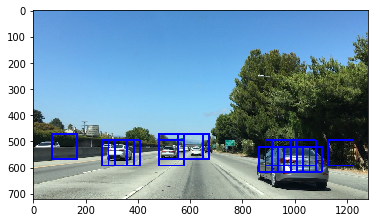

In [5]:
hwindows_list = []
img = mpimg.imread('bbox-example-image.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

%d cars found 3


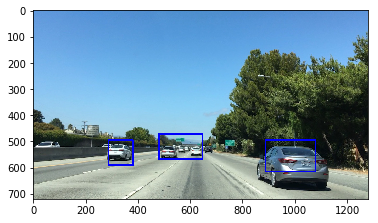

In [7]:
heatmap, draw_img, cars_found = exclude_false_positives(img)

fig = plt.figure()
plt.imshow(draw_img)
print("%d cars found", cars_found)

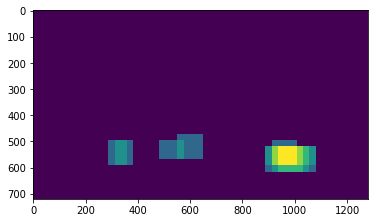

In [8]:
plt.imshow(heatmap)

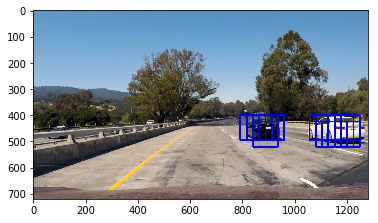

In [13]:
img = mpimg.imread('test_images/test1.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

%d cars found 2


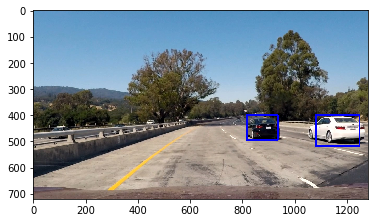

In [14]:
heatmap, draw_img, cars_found = exclude_false_positives(img)

fig = plt.figure()
plt.imshow(draw_img)
print("%d cars found", cars_found)

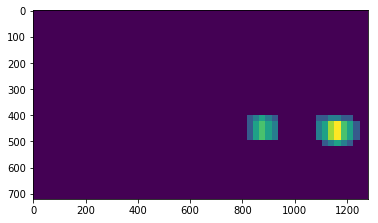

In [15]:
plt.imshow(heatmap)

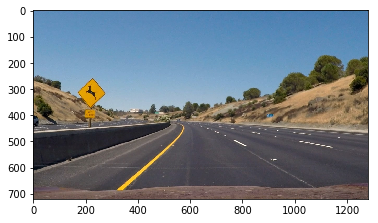

In [16]:
img = mpimg.imread('test_images/test2.jpg')

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

%d cars found 0


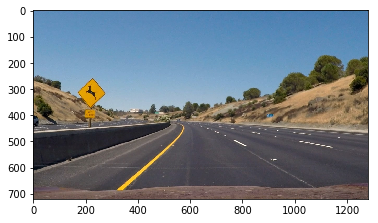

In [17]:
heatmap, draw_img, cars_found = exclude_false_positives(img)

fig = plt.figure()
plt.imshow(draw_img)
print("%d cars found", cars_found)

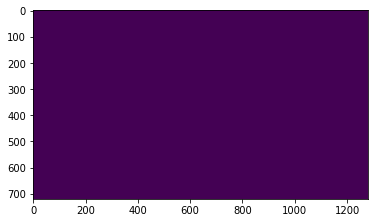

In [18]:
plt.imshow(heatmap)

In [19]:
# The guts of finding lane lines and tracking    
def vehicle_detection_pipeline(image, image_count):
    cars_found_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    heatmap, draw_img, cars_found = exclude_false_positives(image)    
    font = cv2.FONT_HERSHEY_PLAIN
    middlepanel = np.zeros((360, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, 'Frame Count %d' % image_count, (30, 60), font, 3, (255,0,0), 2)
    cv2.putText(middlepanel, 'Cars Found %d' % cars_found, (30, 120), font, 3, (255,0,0), 2)

    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    diagScreen[0:720, 0:1280] = cv2.resize(draw_img, (1280,720), interpolation=cv2.INTER_AREA)
    diagScreen[720:1080, 0:1280] = middlepanel
    diagScreen[0:360, 1280:1920] = cv2.resize(image, (640,360), interpolation=cv2.INTER_AREA) 
    diagScreen[360:720, 1280:1920] = cv2.resize(cars_found_img, (640,360), interpolation=cv2.INTER_AREA)
    diagScreen[720:1080, 1280:1920] = cv2.resize(cv2.cvtColor(np.array(heatmap, dtype=np.uint8), cv2.COLOR_GRAY2RGB), (640,360), interpolation=cv2.INTER_AREA)
    return diagScreen

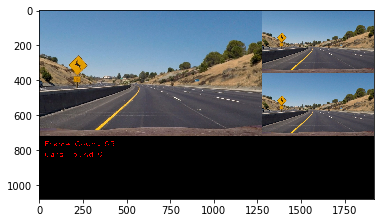

In [20]:
result = vehicle_detection_pipeline(img, 55)

plt.imshow(result)

In [21]:
image_count = 0
def process_image(image):
    global image_count
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = vehicle_detection_pipeline(image, image_count)
    image_count += 1
    return result

In [22]:
video_output = 'project_video_vehicle_detection5.mp4'
video_input = "project_video.mp4"

clip1 = VideoFileClip(video_input)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_vehicle_detection5.mp4
[MoviePy] Writing video project_video_vehicle_detection5.mp4


100%|█████████████████████████████████████▉| 1260/1261 [11:45<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_vehicle_detection5.mp4 

Wall time: 11min 48s
